In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
skip_training = False

In [17]:
from pathlib import Path
work_dir = Path().cwd()/'results'
import os

import ppo_blackjack_train as t
import utils as u

import numpy as np
import torch

In [18]:
cfg_args = {
    "exp_name": "ex1",
    "seed": 2025,
    "env_name": "Blackjack-v1",
    "model_name": "Blackjack-v1",
    "max_episode_steps": 100, # not relevant for Blackjack
    "train_episodes": 50000,
    "batch_size": 256,
    "min_update_samples": 5000,
    "testing": False,
    "model_path": "default",
    "save_video": True,
    "save_model": True,
    "save_logging": True,
    "silent": False,
    "use_wandb": True,
    "run_suffix": 0,
}

In [19]:
if not skip_training:
    t.train(cfg_args=cfg_args)

Numpy/Torch/Random Seed:  2025
Configuration Settings: {'exp_name': 'ex1', 'seed': 2025, 'env_name': 'Blackjack-v1', 'model_name': 'Blackjack-v1', 'max_episode_steps': 100, 'train_episodes': 50000, 'batch_size': 256, 'min_update_samples': 5000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': False, 'use_wandb': True, 'run_suffix': 0}
Training device: cuda
Observation space dimensions: 3
Action space dimensions: 2

Episode 0 finished. Average reward of last 100 steps: -1.0 (1 timesteps)
Episode 500 finished. Average reward of last 100 steps: -0.348 (1 timesteps)
Episode 1000 finished. Average reward of last 100 steps: -0.416 (1 timesteps)
Episode 1500 finished. Average reward of last 100 steps: -0.356 (1 timesteps)
Episode 2000 finished. Average reward of last 100 steps: -0.36 (1 timesteps)
Episode 2500 finished. Average reward of last 100 steps: -0.394 (3 timesteps)
Episode 3000 finished. Average reward of last 100 step

c:\Users\nikov\VS_code_projects\grpo-blackjack\env\Lib\site-packages\gymnasium\wrappers\rendering.py:434: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


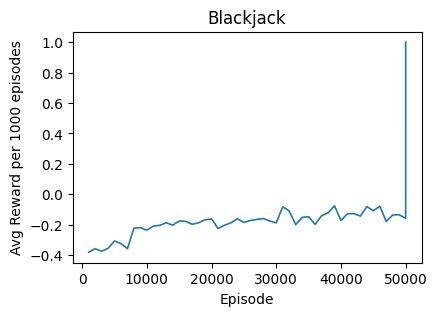

In [20]:
if not skip_training:
    u.plot_reward(Path().cwd()/'results'/'logging'/'Blackjack-v1_2025.csv', 'Blackjack')

In [ ]:
def create_grids_nn(policy, usable_ace=False):
    policy.eval()

    state_value = {}
    policy_action = {}

    for player_sum in range(12, 22):
        for dealer_card in range(1, 11):
            obs = np.array([player_sum, dealer_card, int(usable_ace)], dtype=np.float32)
            obs_t = torch.tensor(obs).unsqueeze(0).to(next(policy.parameters()).device)

            with torch.no_grad():
                action_dist, value = policy(obs_t)

            state_value[(player_sum, dealer_card, usable_ace)] = float(value.item())
            policy_action[(player_sum, dealer_card, usable_ace)] = int(action_dist.probs.argmax().item())

    player_grid, dealer_grid = np.meshgrid(
        np.arange(12, 22),
        np.arange(1, 11),
    )

    value_matrix = np.apply_along_axis(
        lambda arr: state_value[(arr[0], arr[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_grid, dealer_grid]),
    )

    policy_matrix = np.apply_along_axis(
        lambda arr: policy_action[(arr[0], arr[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_grid, dealer_grid]),
    )

    return (player_grid, dealer_grid, value_matrix), policy_matrix

In [ ]:
import matplotlib.pyplot as plt

value_grid_usable_ace, policy_grid_usable_ace = create_grids_nn(policy, usable_ace=True)
fig1 = u.create_plots(value_grid_usable_ace, policy_grid_usable_ace, title="With usable ace")
plt.show()

value_grid_no_ace, policy_grid_no_ace = create_grids_nn(policy, usable_ace=False)
fig2 = u.create_plots(value_grid_no_ace, policy_grid_no_ace, title="Without usable ace")
plt.show()

env.close()
